In [1]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, Add, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import cv2
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
import albumentations as A
!pip install patool

     |████████████████████████████████| 81kB 4.5MB/s 


In [2]:
path = '/content/drive/My Drive/DATAS/База кожных заболеваний/'
img_width = 192 # Ширина уменьшенной картинки 
img_height = 192 # Высота уменьшенной картинки 
directory = 'SkinDiseases/'

In [3]:
import patoolib
if not os.path.exists('SkinDiseases') :
  os.makedirs('SkinDiseases')
patoolib.extract_archive(path + "origin.rar", outdir="SkinDiseases")
patoolib.extract_archive(path + "segmentation.rar", outdir="SkinDiseases")

patool: Extracting /content/drive/My Drive/DATAS/База кожных заболеваний/origin.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/DATAS/База кожных заболеваний/origin.rar"
patool:     with cwd='SkinDiseases'
patool: ... /content/drive/My Drive/DATAS/База кожных заболеваний/origin.rar extracted to `SkinDiseases'.
patool: Extracting /content/drive/My Drive/DATAS/База кожных заболеваний/segmentation.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/DATAS/База кожных заболеваний/segmentation.rar"
patool:     with cwd='SkinDiseases'
patool: ... /content/drive/My Drive/DATAS/База кожных заболеваний/segmentation.rar extracted to `SkinDiseases'.


'SkinDiseases'

In [4]:
num_classes = len(os.listdir(directory + 'origin'))

In [5]:
def rgbToohe(y, num_classes): 
  res = np.zeros((y.shape[0], y.shape[1], num_classes))
  np.place(res[:, :, 0], y[:, :] == 0, 1)
  np.place(res[:, :, 1], y[:, :] == 1, 1)
  return res.astype('bool')

In [6]:
def makeYtrain(Y) :
  res = []
  for j, i in enumerate(Y) :
    res.append(rgbToohe(i, 2))
    if (j % 1000 == 0) :
      print(j)
  return res

In [7]:
X = []
Y = []
for name in os.listdir('SkinDiseases/origin') :
  for filename in os.listdir('SkinDiseases/origin/' + name) :
    img = cv2.resize(cv2.imread(directory + 'origin/' + name + '/' + filename), (img_height, img_width))
    X.append(img.astype('uint8'))
print('origin is ready')
for name in os.listdir('SkinDiseases/segmentation') :
  for filename in os.listdir('SkinDiseases/segmentation/' + name) :
    img = cv2.resize(cv2.imread(directory + 'segmentation/' + name + '/' + filename, cv2.IMREAD_GRAYSCALE), (img_height, img_width))
    img = 1 * img.astype('bool')
    Y.append(img.astype('uint8'))
print('segmentation is ready')

origin is ready
segmentation is ready


Augmentation


In [8]:
aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=img_width, width=img_height, p=0.5),
        A.PadIfNeeded(min_height=img_width, min_width=img_height, p=0.5)
    ],p=1),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)])

random.seed(11)
for i in range(len(X)) :
  augmented = aug(image = X[i], mask = Y[i])

  image_medium = augmented['image'].astype('uint8')
  mask_medium = augmented['mask'].astype('uint8')

  X.append(image_medium)
  Y.append(mask_medium)
X = np.array(X)

In [9]:
Y = makeYtrain(Y) 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [10]:
Y = np.array(Y)

In [11]:
print(X.shape)
print(Y.shape)

(10058, 192, 192, 3)
(10058, 192, 192, 2)


In [12]:
np.random.seed(42)
np.random.shuffle(X)
np.random.shuffle(Y)

In [13]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

## Unet

In [18]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [20]:
modelUnet = unet(2, (img_width, img_height, 3)) # Создаем модель unet
history = modelUnet.fit(X, Y,
                        epochs = 10,
                        batch_size=32,
                        validation_split = 0.2)

Epoch 1/10
252/252 [==============================] - 463s 2s/step - loss: 0.6232 - dice_coef: 0.5761 - val_loss: 1.9476 - val_dice_coef: 0.5072
Epoch 2/10
252/252 [==============================] - 451s 2s/step - loss: 0.6094 - dice_coef: 0.5830 - val_loss: 1.0302 - val_dice_coef: 0.4880
Epoch 3/10
252/252 [==============================] - 450s 2s/step - loss: 0.5962 - dice_coef: 0.5941 - val_loss: 0.6175 - val_dice_coef: 0.6113
Epoch 4/10
252/252 [==============================] - 449s 2s/step - loss: 0.5931 - dice_coef: 0.5966 - val_loss: 0.6005 - val_dice_coef: 0.5906
Epoch 5/10
252/252 [==============================] - 449s 2s/step - loss: 0.5915 - dice_coef: 0.5982 - val_loss: 0.6857 - val_dice_coef: 0.5918
Epoch 6/10
252/252 [==============================] - 448s 2s/step - loss: 0.5910 - dice_coef: 0.5984 - val_loss: 0.6050 - val_dice_coef: 0.6000
Epoch 7/10
252/252 [==============================] - 450s 2s/step - loss: 0.5906 - dice_coef: 0.5986 - val_loss: 0.6117 - val_dic

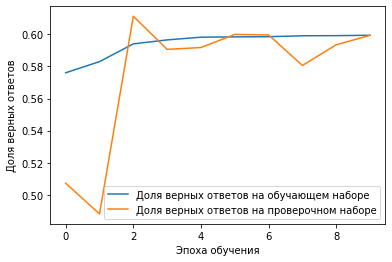

In [21]:
plt.plot(history.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## LinkNet

In [22]:
def linkNet(num_classes = 2, input_shape = (21, 21, 21)) :
  img = Input(input_shape)
  x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(img)
  x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  out1 = x
  x = MaxPooling2D()(out1)
  
  x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
  x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  out2 = x
  x = MaxPooling2D()(out2)

  x = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(x)
  x = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  out3 = x
  x = MaxPooling2D()(out3)

  x = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(x)
  x = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Add()([x, out3])
  x = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(x)
  x = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Add()([x, out2])
  x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
  x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Add()([x, out1])
  x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
  x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(num_classes, (3, 3), padding = 'same', activation = 'softmax')(x)
  model = Model(img, x) 

  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])  
  return model

In [23]:
modelLinkNet = linkNet(2, (img_width, img_height, 3)) # Создаем модель unet
history = modelLinkNet.fit(X, Y,
                        epochs = 10, 
                        batch_size=32,
                        validation_split = 0.2)

Epoch 1/10
252/252 [==============================] - 340s 1s/step - loss: 0.6147 - dice_coef: 0.5800 - val_loss: 0.6112 - val_dice_coef: 0.6039
Epoch 2/10
252/252 [==============================] - 335s 1s/step - loss: 0.5930 - dice_coef: 0.5962 - val_loss: 0.6018 - val_dice_coef: 0.5949
Epoch 3/10
252/252 [==============================] - 336s 1s/step - loss: 0.5907 - dice_coef: 0.5975 - val_loss: 0.5989 - val_dice_coef: 0.5959
Epoch 4/10
252/252 [==============================] - 336s 1s/step - loss: 0.5905 - dice_coef: 0.5975 - val_loss: 0.5983 - val_dice_coef: 0.5970
Epoch 5/10
252/252 [==============================] - 336s 1s/step - loss: 0.5918 - dice_coef: 0.5967 - val_loss: 0.6010 - val_dice_coef: 0.5981
Epoch 6/10
252/252 [==============================] - 334s 1s/step - loss: 0.5897 - dice_coef: 0.5985 - val_loss: 0.5975 - val_dice_coef: 0.5918
Epoch 7/10
252/252 [==============================] - 336s 1s/step - loss: 0.5927 - dice_coef: 0.5968 - val_loss: 0.6085 - val_dic

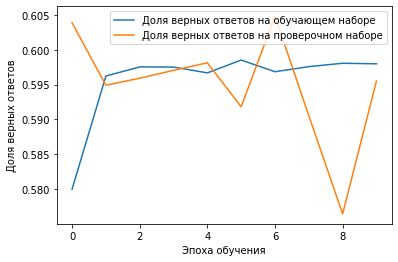

In [24]:
plt.plot(history.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## PSPNet

In [14]:
def PSPNet(num_classes = 2, input_shape = (21, 21, 21)) :
  img = Input(input_shape)
  x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(img)
  x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  block_outs = [i for i in range(4)]
  for i in range(4):
    block_outs[i] = MaxPooling2D((2 ** (i + 1), 2 ** (i + 1)))(x)
  for i in range(4):
    block_outs[i] = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(block_outs[i])
    block_outs[i] = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(block_outs[i])
  for i in range(4):
    block_outs[i] = Conv2DTranspose(64, (3, 3), strides = (2 ** (i + 1), 2 ** (i + 1)), padding = 'same', activation = 'relu')(block_outs[i])
  x = concatenate(block_outs)
  x = Conv2D(num_classes, (3, 3), padding = 'same', activation = 'softmax')(x)
  model = Model(img, x) 

  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])  
  return model

In [15]:
modelPSPNet = PSPNet(2, (img_width, img_height, 3)) # Создаем модель unet
history = modelPSPNet.fit(X, Y,
                        epochs = 10, 
                        batch_size=32,
                        validation_split = 0.2)

Epoch 1/10
252/252 [==============================] - 239s 947ms/step - loss: 0.6080 - dice_coef: 0.5825 - val_loss: 0.6130 - val_dice_coef: 0.5707
Epoch 2/10
252/252 [==============================] - 232s 920ms/step - loss: 0.6040 - dice_coef: 0.5854 - val_loss: 0.6100 - val_dice_coef: 0.5758
Epoch 3/10
252/252 [==============================] - 232s 919ms/step - loss: 0.6024 - dice_coef: 0.5865 - val_loss: 0.6126 - val_dice_coef: 0.5697
Epoch 4/10
252/252 [==============================] - 231s 917ms/step - loss: 0.6028 - dice_coef: 0.5862 - val_loss: 0.6099 - val_dice_coef: 0.5863
Epoch 5/10
252/252 [==============================] - 231s 916ms/step - loss: 0.6030 - dice_coef: 0.5867 - val_loss: 0.6110 - val_dice_coef: 0.5694
Epoch 6/10
252/252 [==============================] - 231s 915ms/step - loss: 0.6028 - dice_coef: 0.5861 - val_loss: 0.6093 - val_dice_coef: 0.5844
Epoch 7/10
252/252 [==============================] - 231s 915ms/step - loss: 0.6020 - dice_coef: 0.5867 - val_l

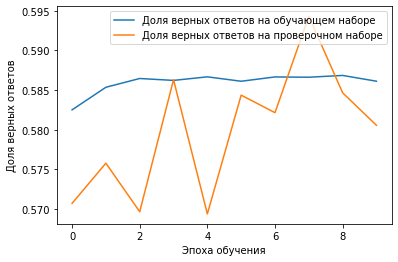

In [16]:
plt.plot(history.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()